# Mineração de Dados: Agrupamento

**Grupo**:

- Gabriel Oliveira Moreira Faria
- Vinícius Oliveira

**Objetivo**:
...


In [3]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustertend
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale

## Análise exploratória

Primeiro, carregaremos os dados e analisaremos as distribuição das características dos grãos e as correlações entre elas.


In [4]:
df = pd.read_csv("data/trabalho4_dados_4.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            1143 non-null   int64  
 1   perimetro       1143 non-null   float64
 2   maior-eixo      1143 non-null   float64
 3   menor-eixo      1143 non-null   float64
 4   arredondamento  1143 non-null   float64
 5   area-convexa    1143 non-null   int64  
 6   extensao        1143 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 62.6 KB


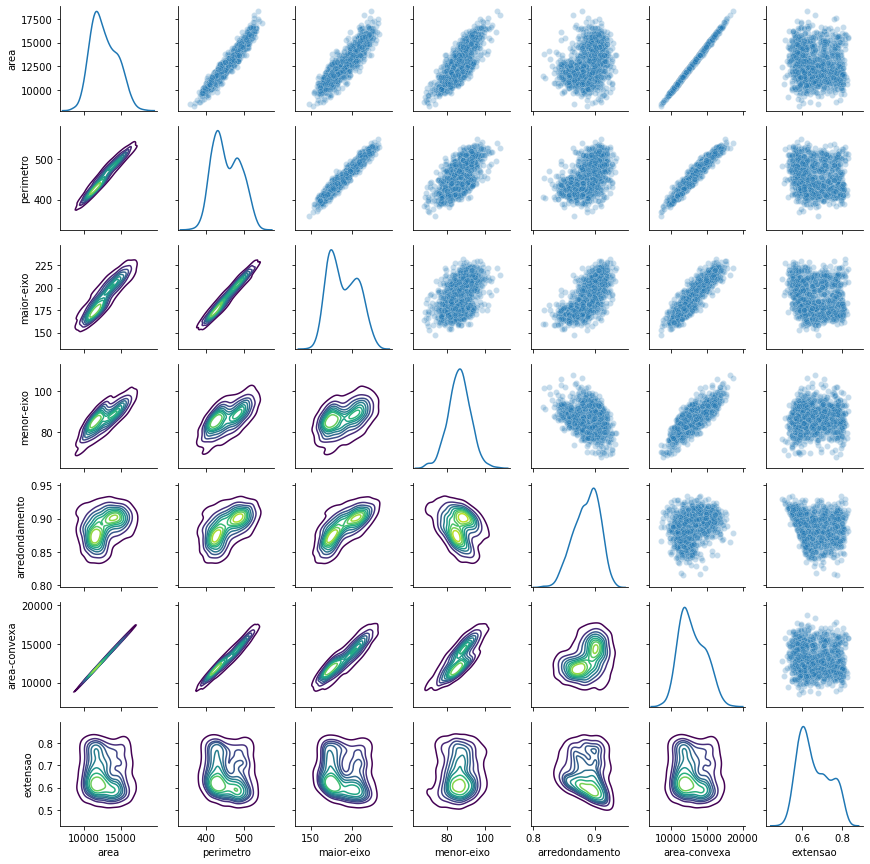

In [5]:
# Distribuição
g = sns.PairGrid(df, diag_sharey=False, height=1.75)
g.map_upper(sns.scatterplot, alpha=0.25)
g.map_lower(sns.kdeplot, cmap="viridis")
g.map_diag(sns.kdeplot);

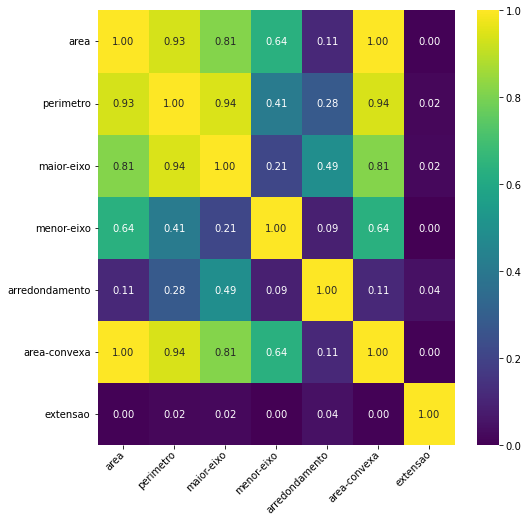

In [6]:
# Correlação linear (R^2)
plt.figure(figsize=(8, 8))
corr = df.corr()
g = sns.heatmap(corr ** 2, annot=True, vmin=0, vmax=1, fmt=".2f", cmap="viridis")
g.set_xticklabels(
    g.get_xticklabels(), rotation=45, va="center", ha="right", rotation_mode="anchor"
);

O primeiro gráfico revela duas informações interessantes:

- Em diversas das projeções, existem um ou dois picos de densidade bem definidos. Os dados projetados são facilmente separados em dois grupos.
- Algumas das características são fortemente correlacionadas (linearmente). Nesse caso, as características são redundantes para a tarefa de agrupamento e podemos remover algumas delas.
  - O segundo gráfico exibe as correlações lineares através do índice $R^2$.


## Tendência de agrupamento

A seguir, verificaremos a aleatoriedade espacial dos dados através da estatística de Hopkins para diferentes configurações de características (100 vezes cada). Mas, antes, padronizaremos os dados.


In [7]:
# Padronizar os dados
X = pd.DataFrame()
X[df.columns] = scale(df[df.columns])
X.describe()

,area,perimetro,maior-eixo,menor-eixo,arredondamento,area-convexa,extensao
count,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03
mean,-3.590013e-16,1.272240e-15,1.225811e-16,6.478729e-16,3.847025e-15,2.121371e-16,-1.798892e-16
std,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00
min,-2.509628e+00,-2.693842e+00,-2.380168e+00,-3.183893e+00,-3.452512e+00,-2.465338e+00,-2.121627e+00
25%,-7.619569e-01,-7.912156e-01,-8.540997e-01,-6.369296e-01,-7.025409e-01,-7.709632e-01,-8.121555e-01
50%,-1.415949e-01,-1.476076e-01,-1.628963e-01,1.628585e-02,1.245985e-01,-1.280779e-01,-2.334658e-01
75%,7.434967e-01,8.031325e-01,8.563650e-01,6.295541e-01,7.648869e-01,7.596369e-01,7.760474e-01
max,3.181061e+00,2.603008e+00,2.439498e+00,3.583633e+00,2.293564e+00,3.166848e+00,2.215740e+00


In [8]:
column_combinations = [
    list(cols)
    for n_cols in range(2, len(X.columns) + 1)
    for cols in it.combinations(X.columns, n_cols)
]

In [9]:
H_SCORES_PATH = "data/h_scores.pkl"
try:
    with open(H_SCORES_PATH, "rb") as file:
        h_scores = pickle.load(file)
except FileNotFoundError:
    result = dict(cols=[], score=[])
    for cols in column_combinations:
        X_proj = X[list(cols)]
        for _ in range(100):
            result["cols"].append(frozenset(cols))
            result["score"].append(
                pyclustertend.hopkins(X_proj, sampling_size=len(X_proj))
            )
    result = pd.DataFrame(result)
    h_scores = pd.DataFrame()
    h_scores["mean"] = result.groupby("cols")["score"].mean()
    h_scores["std"] = result.groupby("cols")["score"].std()
    with open(H_SCORES_PATH, "wb") as file:
        pickle.dump(h_scores, file)

In [10]:
print("Projeções com H<0.5:", (h_scores["mean"] < 0.5).sum())
h_scores.sort_values(by="mean", ascending=True).head(n=5)

Projeções com H<0.5: 120


,mean,std
cols,,
"(area-convexa, area)",0.011505,0.000236
"(area-convexa, perimetro, area)",0.028419,0.000383
"(area-convexa, perimetro)",0.034838,0.000896
"(perimetro, area)",0.036361,0.001122
"(maior-eixo, perimetro)",0.038670,0.000978


A tabela acima mostra que as cinco melhores projeções de acordo com a estatística de Hopkins contêm apenas um topo na distribuição dos pontos (exceto, possivelmente, o último caso). Ao usar uma dessas projeções, a tendência é que haja um grupo principal e um grupo de 'outliers'. Isso porque a estatística de Hopkins testa apenas a uniformidade dos dados. Uma boa pontuação não implica na tendência de _múltiplos_ grupos convexos. Logo, a estatística não é apropriada para selecionar a melhor projeção.

Além disso, todas as 120 projeções possíveis são potencialmente agrupáveis de acordo com a estatística.

Portanto, não faremos nenhum pré-processamento baseado nos melhores resultados de $H$. Escolheremos a combinação ótima das características na etapa a seguir.


## Algoritmos de agrupamento e otimização de parâmetros

Agora, analisaremos o desempenho de alguns algoritmos de agrupamento em diferentes configurações de características e parâmetros de modelo. Para isso, faremos uma busca em grade usando o _coeficiente de silhueta como critério de otimização_.

A busca otimizará simultaneamente o algoritmo utilizado, seus parâmetros e as características utilizadas. Cada configuração será testada 5 vezes.

> Nota: aqui, poderíamos limitar o espaço de busca de projeções de características usando os valores da estatística de Hopkins calculados na etapa anterior. Poderíamos também usar os valores de $R^2$ calculados na primeira etapa.


In [11]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        pass

    def transform(self, X, y=None):
        if self.columns is not None:
            X = X[self.columns]
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X, y)


def score_wrapper(pipe, X_test):
    estimator = pipe[-1]
    y = estimator.labels_
    if len(np.unique(y)) == 1:
        return -1
    return silhouette_score(X, y)

In [12]:
SEARCH_RESULTS_PATH = "data/search_results.pkl"
try:
    with open(SEARCH_RESULTS_PATH, "rb") as file:
        search_results = pickle.load(file)
except FileNotFoundError:
    pipe = pipe = Pipeline(
        [
            ("select", ColumnSelector()),
            ("estimator", KMeans()),  # dummy
        ]
    )
    search = GridSearchCV(
        pipe,
        param_grid=[
            {
                "select__columns": column_combinations,
                "estimator": [KMeans()],
                "estimator__n_clusters": [2, 3, 4, 5, 7, 10],
            },
            {
                "select__columns": column_combinations,
                "estimator": [AgglomerativeClustering()],
                "estimator__n_clusters": [2, 3, 4, 5, 7, 10],
                "estimator__linkage": ["ward", "complete", "average", "single"],
            },
            {
                "select__columns": column_combinations,
                "estimator": [DBSCAN()],
                "estimator__eps": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
                "estimator__min_samples": [2, 3, 4, 5, 10, 20],
                "estimator__p": [1, 2],
            },
            {
                "select__columns": column_combinations,
                "estimator": [OPTICS()],
                "estimator__min_samples": [2, 3, 4, 5, 10, 20],
                "estimator__p": [1, 2],
            },
        ],
        scoring=score_wrapper,
        # Os dados DEVEM ser testados no conjunto de treino
        cv=[(list(range(len(X))), list(range(len(X))))] * 5,
        n_jobs=-1,
    )
    _ = search.fit(X)
    search_results = pd.DataFrame(search.cv_results_).sort_values(
        by="mean_test_score", ascending=False
    )
    with open(SEARCH_RESULTS_PATH, "wb") as file:
        pickle.dump(search_results, file)

In [13]:
best_result = search_results["params"][search_results.index[0]].copy()
best_result["select__columns"] = [best_result["select__columns"]]
pd.DataFrame(best_result)

,estimator,estimator__eps,estimator__min_samples,estimator__p,select__columns
0,DBSCAN(p=1),1.0,3,1,"[area, perimetro, menor-eixo, area-convexa, ex..."


## Resultados

Analisemos agora os resultados. Primeiro, examinaremos o processo de busca de parâmetros. Depois, estudaremos os detalhes do agrupamento em si.


,param_estimator,mean_test_score,std_test_score,param_select__columns,rank_test_score
9699,DBSCAN(p=1),0.454362,5.551115e-17,"[area, perimetro, menor-eixo, area-convexa, ex...",1
2908,AgglomerativeClustering(),0.432589,0.000000e+00,"[area, maior-eixo, area-convexa]",69
81,KMeans(),0.414547,0.000000e+00,"[perimetro, maior-eixo, area-convexa, extensao]",421
13586,OPTICS(),0.357022,0.000000e+00,"[area, maior-eixo, menor-eixo]",1413


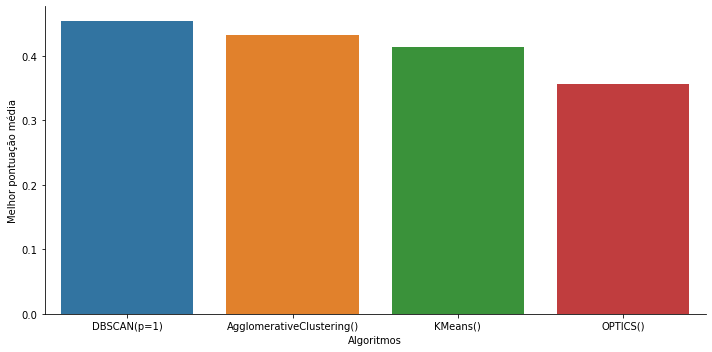

In [14]:
key = lambda x: str(search_results.loc[x, "param_estimator"])
group = search_results.groupby(key)
idx = group["mean_test_score"].transform(max) == search_results["mean_test_score"]
models_results = (
    search_results[idx]
    .sort_values("std_test_score")
    .sort_values("mean_test_score", ascending=False)
    .drop_duplicates("param_estimator")
)
models_results["model"] = models_results["param_estimator"].map(str)

g = sns.catplot(
    data=models_results,
    x="model",
    y="mean_test_score",
    kind="bar",
    aspect=2,
)
g.ax.set_xlabel("Algoritmos")
g.ax.set_ylabel("Melhor pontuação média")

models_results[
    [
        "param_estimator",
        "mean_test_score",
        "std_test_score",
        "param_select__columns",
        "rank_test_score",
    ]
]

O gráfico acima mostra que o algoritmo DBSCAN, com determinado conjunto de parâmetros e características, obteve o melhor resultado.

Antes de continuarmos a análise dos algoritmos, vamos estudar a sensibilidade da qualidade dos resultados com relação à escolha das características.


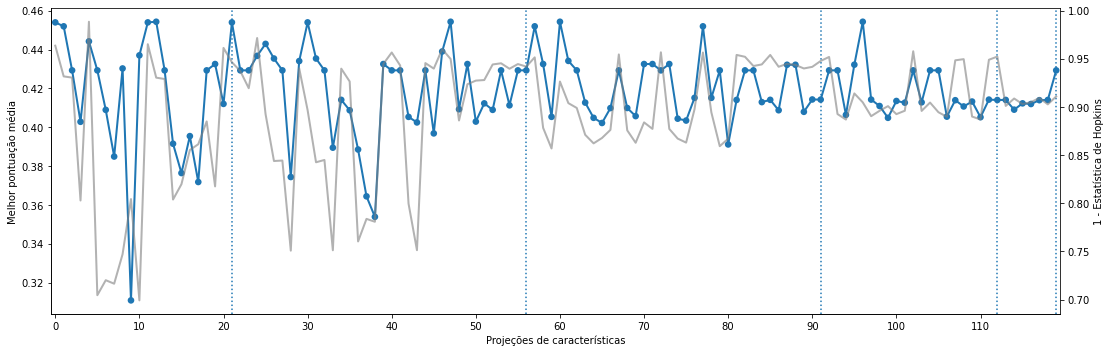

In [15]:
# Ordenar caractrerísticas de forma que elementos adjacentes
# estejam a uma modificação de distância
indices = [frozenset(column_combinations[0])]
curr_len = min(len(cols) for cols in column_combinations)
while len(indices) < len(column_combinations):
    n_appended = 0
    for cols in column_combinations:
        cols = frozenset(cols)
        last = indices[-1]
        if len(cols) != curr_len or cols in indices:
            continue
        if cols > last:
            distance = len(cols - last)
        else:
            distance = len(last - cols)
        if distance == 1:
            indices.append(cols)
            n_appended += 1
    if n_appended == 0:
        curr_len += 1

# Performance score
key = lambda x: frozenset(search_results.loc[x, "param_select__columns"])
group = search_results.groupby(key)

plt_data = pd.DataFrame(group["mean_test_score"].max())
kk = plt_data.copy()
plt_data = plt_data.reindex(indices)
plt_data["index"] = list(range(len(plt_data)))
plt_data["n_features"] = plt_data.index.map(len)

g = sns.catplot(
    data=plt_data,
    x="index",
    y="mean_test_score",
    kind="point",
    aspect=3,
    scale=0.75,
)
g.ax.set_xlabel("Projeções de características")
g.ax.set_ylabel("Melhor pontuação média")
for i, (x1, x2) in enumerate(zip(plt_data["n_features"], plt_data["n_features"][1:])):
    if x1 != x2:
        g.ax.axvline(x=i + 1, ls=":")

# H-score
plt_data = h_scores.reindex(plt_data.index)
ax2 = g.ax.twinx()
sns.pointplot(
    x=list(range(len(plt_data))),
    y=1 - plt_data["mean"],
    ax=ax2,
    color="grey",
    scale=0.75,
)
ax2.set_ylabel("1 - Estatística de Hopkins")
ax2.set_xticks(list(range(0, len(plt_data), 10)))
plt.setp(ax2.collections, alpha=0)
plt.setp(ax2.lines, alpha=0.6);

O gráfico acima possui uma propriedade especial: da esquerda para a direita, o número de características é crescente e entre quaisquer duas projeções adjacentes, o conjunto de características difere em exatamente uma coluna. Com isso, é possível observar tanto a sensibilidade global, quanto a sensibilidade a pequenas mudanças.

Podemos fazer as seguintes observações:

- A qualidade do agrupamento se altera significativamente com a mudança das características, especialmente quando o número de características é pequeno.
- A estatística de Hopkins é significativamente correlacionada com o coeficiente de silhueta, apesar de não ser capaz de prever a melhor configuração. Entretanto, o gráfico revela que se tivéssemos buscado apenas características com $H > 0.9$, por exemplo, ainda teríamos encontrado as melhores soluções.

> Em um cenário mais complexo, poderíamos inclusive fazer uma busca de parâmetros iterativa, diminuindo o limiar de $H$ a cada iteração.


### Agrupamento

Analisemos agora o agrupamento de cada algoritmo em divsersas projeções do conjunto de dados, incluindo uma PCA.


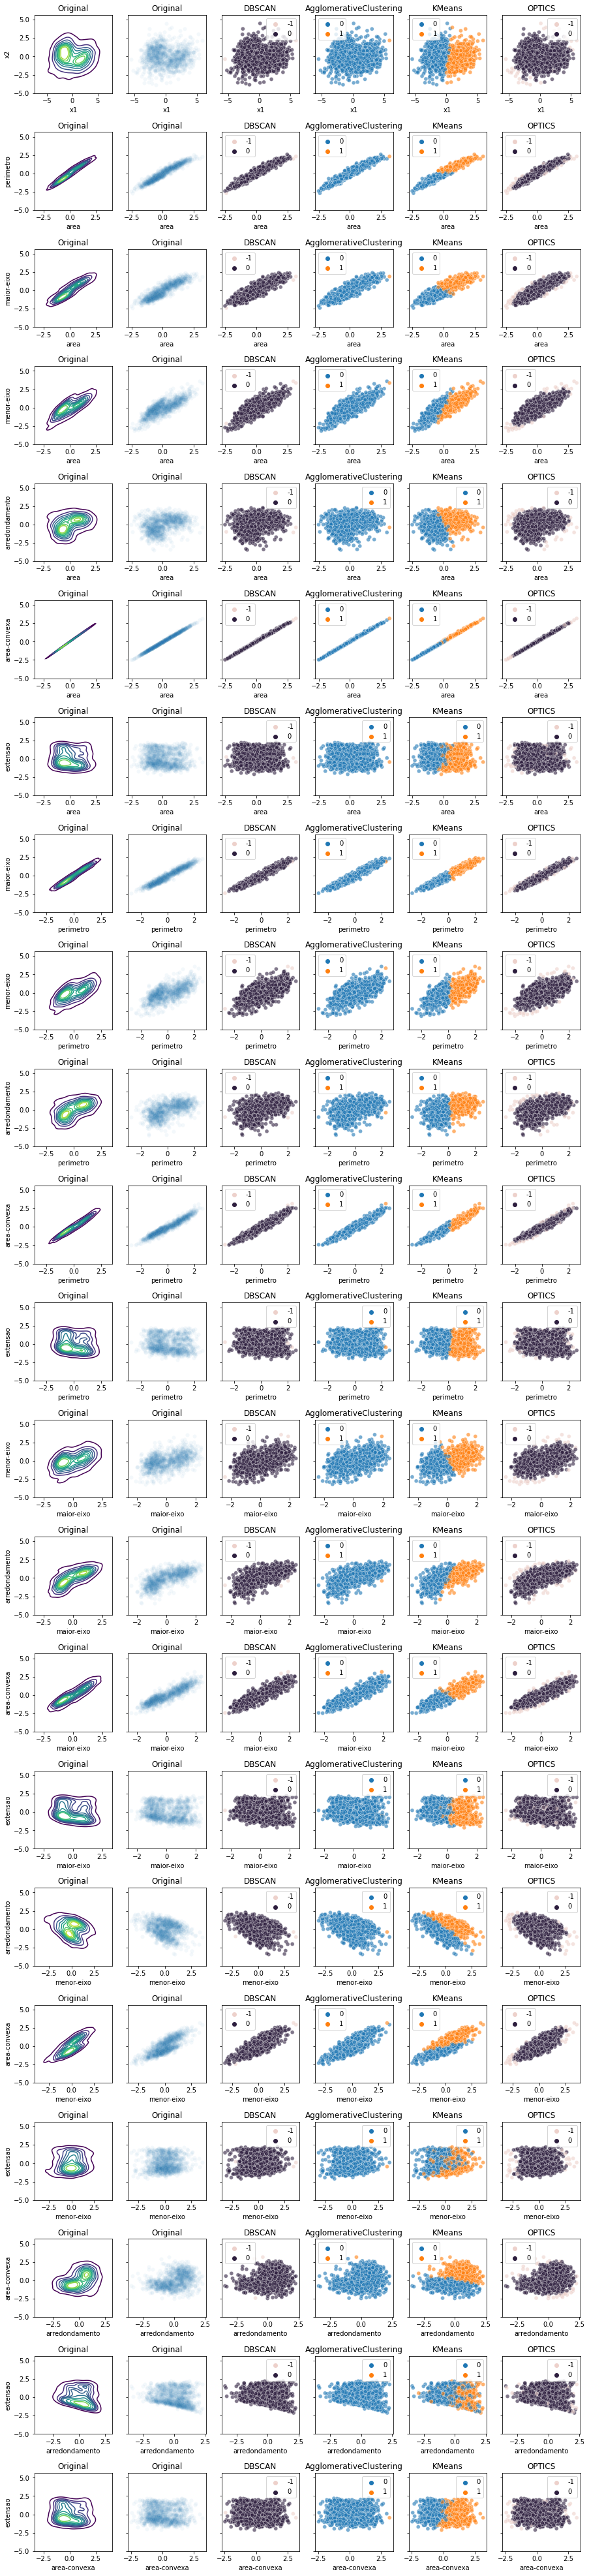

In [16]:
def make_estimator(params):
    pipe = Pipeline(
        [
            ("select", ColumnSelector()),
            ("estimator", KMeans()),  # dummy
        ]
    )
    pipe.set_params(**params)
    return pipe


estimators = models_results["params"].map(make_estimator)
predictions = [estimator.fit_predict(X) for estimator in estimators]

pca_projection = PCA(n_components=2).fit_transform(X)
pca_projection = pd.DataFrame(pca_projection, columns=["x1", "x2"])
projections = [
    pca_projection,
    *[X[list(cols)] for cols in it.combinations(X.columns, 2)],
]

fig, ax = plt.subplots(
    nrows=len(projections),
    ncols=len(models_results) + 2,
    sharey=True,
    figsize=(15, 3.25 * len(projections)),
)
plt.subplots_adjust(hspace=0.5)
for j, data in enumerate(projections):
    g = sns.kdeplot(
        data=data, x=data.columns[0], y=data.columns[1], cmap="viridis", ax=ax[j, 0]
    )
    ax[j, 0].set_title("Original")
    g = sns.scatterplot(
        data=data,
        x=data.columns[0],
        y=data.columns[1],
        cmap="viridis",
        ax=ax[j, 1],
        alpha=0.05,
    )
    ax[j, 1].set_title("Original")
    for i, (estimator, y_pred) in enumerate(zip(estimators, predictions)):
        g = sns.scatterplot(
            data=data,
            x=data.columns[0],
            y=data.columns[1],
            hue=y_pred,
            alpha=0.6,
            ax=ax[j, i + 2],
        )
        g.set_title(str(estimator["estimator"]).split("(")[0])

[...: o coeficiente de silhueta se comporta de forma diferente para grupos não convexos]

Como a diferença de densidade é muito maior entre o centro das nuvens e as extremidades do que entre os picos, os métodos baseados em densidade tendem a agrupar os elementos em "centrais" e "não-centrais".

Por outro lado, o KMeans, limitado a agrupamentos convexos, tende a dividir os dados de acordo com os picos de densidade. Na projeção da PCA, observa-se que há dois grupos bem definidos e que são separados com sucesso por esses dois algoritmos. Além disso, com exceção das projeções envolvendo a característica "extensão", o centróides dos grupos obtidos são capazes de capturar vários picos de densidade de probabilidade.

Portanto, vamos caracterizar os dados baseando-nos nos grupos gerados pelo KMeans. Analisemos agora as características de cada grupo individualmente.


### Caracterização


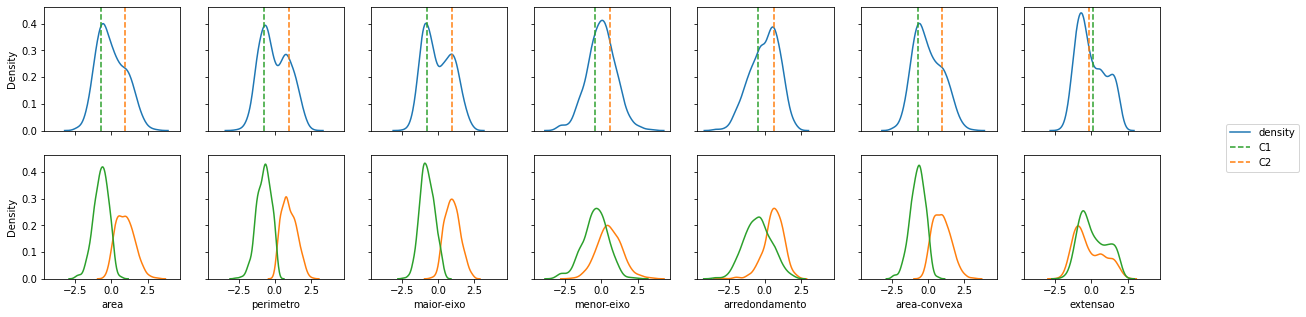

In [18]:
model = next(estimator for estimator in estimators if "KMeans" in str(estimator))[-1]
centroids = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(X.columns),
    sharey=True,
    sharex=True,
    figsize=(20, 5),
)

ignore = []
colors = ["tab:green", "tab:orange", "tab:purple"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(centroids):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k+1}" for k in range(len(centroids))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(centroids)],
        legend=None,
    )

Baseado nas distribuições, poderíamos testar a significância estatística da diferença entre os grupos.